In [1]:
# Read json file
import json
import numpy as np
import requests
import os
import pandas as pd
from sklearn import preprocessing
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings

In [2]:
playlists = json.load(open('playlists.json', 'r'))
tracks = json.load(open('track_features.json', 'r'))

In [3]:
def get_cluster_tracks(playlists_df, cluster_preds, num_clusters, verbose=False):
    global playlists, tracks
    
    playlists_clustered = playlists_df.get(['index', 'title']).copy()
    playlists_clustered['cluster'] = cluster_preds

    cluster_tracks = [{} for _ in range(num_clusters)]
    for cluster in range(num_clusters):
        for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
            for track in playlists[i][1]:
                if track['track_uri'] not in cluster_tracks[cluster]:
                    cluster_tracks[cluster][track['track_uri']] = track
        cluster_tracks[cluster] = np.array(list(cluster_tracks[cluster].values()))

        if verbose:
            print('Cluster {}: {} tracks'.format(cluster, len(cluster_tracks[cluster])))

    return cluster_tracks

def cluster_custom_score(playlists_df, cluster_preds, num_clusters):
    global tracks
    
    cluster_tracks = get_cluster_tracks(playlists_df, cluster_preds, num_clusters)

    lengths = np.array([len(tracks) for tracks in cluster_tracks])

    return np.sum(lengths) / len(tracks), \
        np.max(lengths) / len(tracks), \
        np.std(lengths) / np.mean(lengths)

In [4]:
duplication_factors = []
reduction_factors = []
variation_coefficients = []
davies_bouldins = []

In [5]:
playlists_df = pd.read_csv('playlists.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [6]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.00631655630708, CTRF = 0.6398141457694175, CCV = 0.2715961826512505, DB = 1.5499797781262485
K = 3, CTDF = 1.0358826595278425, CTRF = 0.5752300967768683, CCV = 0.5960663149840372, DB = 1.5380131493438556
K = 4, CTDF = 1.1348686938084127, CTRF = 0.41787884531100083, CCV = 0.45436957472741324, DB = 1.7068494614845537
K = 5, CTDF = 1.2019195460845051, CTRF = 0.3206636974212577, CCV = 0.3725935510960383, DB = 1.7157063598849223
K = 6, CTDF = 1.2527747835254261, CTRF = 0.2872715319647955, CCV = 0.3904729734966785, DB = 1.7661064928903503
K = 7, CTDF = 1.3087235403513344, CTRF = 0.2420221271958399, CCV = 0.32230320349437264, DB = 1.7459275061880697
K = 8, CTDF = 1.318226507622511, CTRF = 0.2441513367527037, CCV = 0.4176398490375946, DB = 1.6580746811491074
K = 9, CTDF = 1.3675773800357731, CTRF = 0.21786048495042704, CCV = 0.3836969464012327, DB = 1.7372477600456848
K = 10, CTDF = 1.3786054417739662, CTRF = 0.21508274007652126, CCV = 0.45273604746381707, DB = 1.7136125307738


In [7]:
playlists_df = pd.read_csv('playlists_embeddings.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [8]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.0072019995024935, CTRF = 0.6330593098873503, CCV = 0.25706523656634794, DB = 2.4422086971906394
K = 3, CTDF = 1.1058297106170265, CTRF = 0.4458487817012355, CCV = 0.17512413826668433, DB = 3.2330239855985545
K = 4, CTDF = 1.1837368664194927, CTRF = 0.433793132040606, CCV = 0.40252748682347844, DB = 3.0480227020348156
K = 5, CTDF = 1.2583835775458714, CTRF = 0.4146124779379538, CCV = 0.475897227245721, DB = 2.820898887341798
K = 6, CTDF = 1.1937373402352496, CTRF = 0.5202171260705275, CCV = 0.9003646984595678, DB = 2.1219352941680993
K = 7, CTDF = 1.207495765271674, CTRF = 0.49884211274445933, CCV = 0.9401104986806518, DB = 2.1717501068998066
K = 8, CTDF = 1.3600999751246727, CTRF = 0.32584901860911386, CCV = 0.5727614349355563, DB = 2.5138973788664405
K = 9, CTDF = 1.333643287807536, CTRF = 0.42719228627948025, CCV = 0.8222049636978302, DB = 2.305803685959574
K = 10, CTDF = 1.385869629594532, CTRF = 0.4217137915921394, CCV = 0.8207520851504622, DB = 2.1936028850455758
K

In [9]:
playlists_df = pd.read_csv('playlists_embeddings.csv')
cols = ['danceability', 'energy', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature']
playlists_df = playlists_df.drop(cols, axis=1)

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [10]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.09142275026356, CTRF = 0.7293505170514445, CCV = 0.336513311409935, DB = 4.016999209969487
K = 3, CTDF = 1.2077060210137287, CTRF = 0.6282471186079293, CCV = 0.4747832554080583, DB = 3.445590641437286
K = 4, CTDF = 1.2607615403750252, CTRF = 0.6269322798829675, CCV = 0.6651112831908897, DB = 2.8153166824764995
K = 5, CTDF = 1.2920926072896555, CTRF = 0.6327898271757028, CCV = 0.8257051917319687, DB = 2.4456407132882396
K = 6, CTDF = 1.41198576183651, CTRF = 0.6049028085428981, CCV = 0.7708781804694095, DB = 2.309034067408375
K = 7, CTDF = 1.5102255363002097, CTRF = 0.5376565072671492, CCV = 0.6818576861415996, DB = 2.2279008440150254
K = 8, CTDF = 1.3857778277916633, CTRF = 0.6373651105767523, CCV = 1.1100242398829736, DB = 1.8115267362213352
K = 9, CTDF = 1.511910543585127, CTRF = 0.5292314708425628, CCV = 0.9147240011307202, DB = 1.7941452066670631
K = 10, CTDF = 1.5867378969687638, CTRF = 0.49250778834650144, CCV = 0.8358342093523712, DB = 1.7736736451464403
K = 11, 

In [11]:
playlists_df = pd.read_csv('playlists_popularity.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [12]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.0081673991068574, CTRF = 0.6239057817367717, CCV = 0.2377027511294141, DB = 1.6120377057064492
K = 3, CTDF = 1.03806517335734, CTRF = 0.5529844469977849, CCV = 0.575480942735404, DB = 1.6119604170568131
K = 4, CTDF = 1.1333169472050793, CTRF = 0.4421796709349569, CCV = 0.47400366491987606, DB = 1.8098523007058214
K = 5, CTDF = 1.208810603996636, CTRF = 0.32180381658592055, CCV = 0.37800321496496925, DB = 1.761770413506865
K = 6, CTDF = 1.2586530602575188, CTRF = 0.29638360123665913, CCV = 0.3559872891406246, DB = 1.8158758505373636
K = 7, CTDF = 1.3065232584309592, CTRF = 0.27061986946375904, CCV = 0.33750430720279734, DB = 1.841194843162077
K = 8, CTDF = 1.3188513521517158, CTRF = 0.2653190556851968, CCV = 0.42815659031160236, DB = 1.7508689623687728
K = 9, CTDF = 1.319197829923834, CTRF = 0.26654209260728967, CCV = 0.5721554142149375, DB = 1.5994337533206469
K = 10, CTDF = 1.3485773681903792, CTRF = 0.2564202035038675, CCV = 0.5678055544638475, DB = 1.6493792576024267

In [13]:
playlists_df = pd.read_csv('playlists_popularity.csv')
playlists_df = playlists_df.drop(cols, axis=1)

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [14]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.077160895985596, CTRF = 0.7194240769476788, CCV = 0.3357783031835927, DB = 1.1501494374361285
K = 3, CTDF = 1.2220952132763174, CTRF = 0.6576858838440672, CCV = 0.43481110264121425, DB = 0.9808924551622088
K = 4, CTDF = 1.353913718150697, CTRF = 0.443849871477476, CCV = 0.2846621671117766, DB = 1.0047667050010527
K = 5, CTDF = 1.3881261771360207, CTRF = 0.5210848011750631, CCV = 0.5432789753483587, DB = 0.9952562865926955
K = 6, CTDF = 1.4574394996505609, CTRF = 0.45757276033214483, CCV = 0.5493055097063395, DB = 0.8642005108332719
K = 7, CTDF = 1.5064231648523472, CTRF = 0.3947329455941057, CCV = 0.5505260979587959, DB = 0.8860101205636439
K = 8, CTDF = 1.5734177515073264, CTRF = 0.3159285012023075, CCV = 0.5376353279635795, DB = 0.8779966762134832
K = 9, CTDF = 1.6052285568756588, CTRF = 0.3446831949396477, CCV = 0.6020500014533321, DB = 0.8788139616921078
K = 10, CTDF = 1.6579909027374706, CTRF = 0.3423644590800867, CCV = 0.5919096190562323, DB = 0.8750913454240796
K

In [15]:
playlists_df = pd.read_csv('playlists_min_max.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [16]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.0318878004288032, CTRF = 0.5768825292285095, CCV = 0.11811095932868802, DB = 2.158592266829307
K = 3, CTDF = 1.120443965364068, CTRF = 0.6528766539131259, CCV = 0.5296755220849085, DB = 2.342837357444387
K = 4, CTDF = 1.1506734106442709, CTRF = 0.5668731713673139, CCV = 0.6695228780227629, DB = 2.210752256036049
K = 5, CTDF = 1.2083427109368523, CTRF = 0.546608663721112, CCV = 0.6939104083497265, DB = 2.2123493026527212
K = 6, CTDF = 1.2206411911728126, CTRF = 0.5497832292912901, CCV = 0.8500137798356825, DB = 2.0887553854565035
K = 7, CTDF = 1.2981841011122826, CTRF = 0.443159877281719, CCV = 0.7783189874677231, DB = 2.0750511750261995
K = 8, CTDF = 1.3380260835574087, CTRF = 0.41942763056585447, CCV = 0.7699291570899972, DB = 2.130735664490715
K = 9, CTDF = 1.3439961620923704, CTRF = 0.42209580554601345, CCV = 0.8597276423196102, DB = 2.017814415455812
K = 10, CTDF = 1.3534783999241895, CTRF = 0.41280901671385084, CCV = 0.9446324199717985, DB = 1.9331597006023507
K = 

In [17]:
playlists_df = pd.read_csv('playlists_std.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [18]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.0277774487390579, CTRF = 0.5394362777034151, CCV = 0.04971417375469654, DB = 1.9167400694179866
K = 3, CTDF = 1.057778870186328, CTRF = 0.47350777650110754, CCV = 0.48470356619295035, DB = 1.8964520284312358
K = 4, CTDF = 1.1372407339406072, CTRF = 0.4082248492673624, CCV = 0.437750188484092, DB = 2.0945965680644947
K = 5, CTDF = 1.1400717830871465, CTRF = 0.4129630068347923, CCV = 0.6882573799933525, DB = 1.9030311629541798
K = 6, CTDF = 1.2231909122137856, CTRF = 0.395171225169093, CCV = 0.6234059435528343, DB = 2.0039080600865216
K = 7, CTDF = 1.2513266841188804, CTRF = 0.3734082751921915, CCV = 0.6365427468540893, DB = 1.9666369575330818
K = 8, CTDF = 1.3458410821951885, CTRF = 0.3191415643027209, CCV = 0.4281192537892725, DB = 2.183675379853219
K = 9, CTDF = 1.347914026130939, CTRF = 0.3151496665521612, CCV = 0.5688748497594317, DB = 2.0084334530300203
K = 10, CTDF = 1.3917834425083806, CTRF = 0.24287203420949763, CCV = 0.47367978350230283, DB = 1.9935474037141359


In [19]:
playlists_df = pd.read_csv('playlists.csv')
playlists_df = playlists_df.drop(['key'], axis=1)

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [20]:
duplication_factors.append([])
reduction_factors.append([])
variation_coefficients.append([])
davies_bouldins.append([])

for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++', n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    duplication_factor, reduction_factor, variation_coefficient = \
        cluster_custom_score(playlists_df, labels, i)

    davies_bouldin = davies_bouldin_score(playlists_df[headers[2:]], labels)
    
    duplication_factors[-1].append(duplication_factor)
    reduction_factors[-1].append(reduction_factor)
    variation_coefficients[-1].append(variation_coefficient)
    davies_bouldins[-1].append(davies_bouldin)

    print('K = {}, CTDF = {}, CTRF = {}, CCV = {}, DB = {}'.format(
        i, duplication_factor, reduction_factor, variation_coefficient, davies_bouldin))

K = 2, CTDF = 1.005576219187169, CTRF = 0.6420292344321911, CCV = 0.2769379827839572, DB = 1.4654686276306308
K = 3, CTDF = 1.1014232240793167, CTRF = 0.46154392864334703, CCV = 0.19731686324352066, DB = 1.7641072396838524
K = 4, CTDF = 1.1343386124305563, CTRF = 0.41956977529287737, CCV = 0.4540035103861428, DB = 1.5942799597931674
K = 5, CTDF = 1.195878395186032, CTRF = 0.3372620556496606, CCV = 0.4596873162134313, DB = 1.6850667006131737
K = 6, CTDF = 1.252309851814122, CTRF = 0.2890661091434596, CCV = 0.38975493166776964, DB = 1.621937479029282
K = 7, CTDF = 1.308169768185641, CTRF = 0.2401505549567051, CCV = 0.3198381622131588, DB = 1.603522531290606
K = 8, CTDF = 1.3180132905319766, CTRF = 0.23591878797929425, CCV = 0.41451478340214776, DB = 1.5221348190740995
K = 9, CTDF = 1.3184871062887196, CTRF = 0.23550419919214413, CCV = 0.5616603792852226, DB = 1.3902574884397705
K = 10, CTDF = 1.3398710036602268, CTRF = 0.23694637590173062, CCV = 0.5703007655968377, DB = 1.373879634219408

In [21]:
labels = ['Original', 'Embeddings', 'Embeddings only',
          'Popularity', 'Popularity only', 'Min-max', 'Std', 'No key']

Text(0.5, 1.0, 'CTDF vs. Number of Clusters')

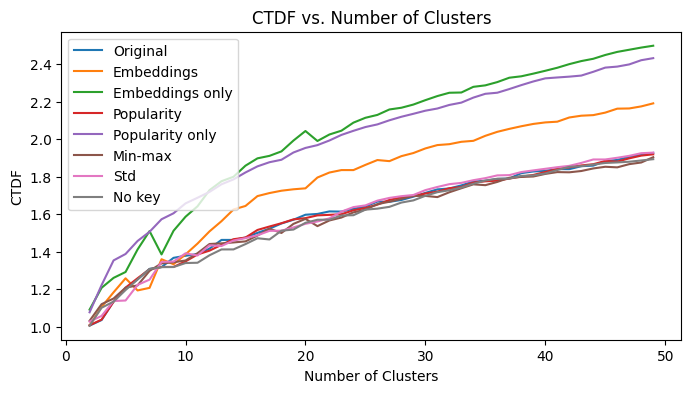

In [22]:
plt.figure(figsize=(8, 4))
for i in range(len(labels)):
    plt.plot(range(2, 50), duplication_factors[i], label=labels[i]) # Cluster Track Duplication Factor
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('CTDF')
plt.title('CTDF vs. Number of Clusters')

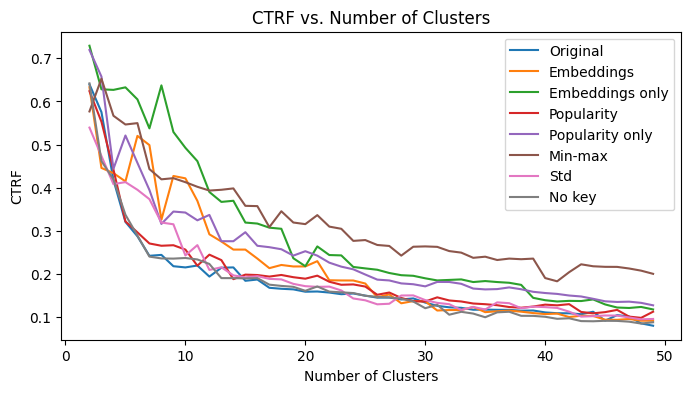

In [23]:
plt.figure(figsize=(8, 4))
for i in range(len(labels)):
    plt.plot(range(2, 50), reduction_factors[i], label=labels[i]) # Cluster Track Reduction Factor
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('CTRF')
plt.title('CTRF vs. Number of Clusters')
plt.show()

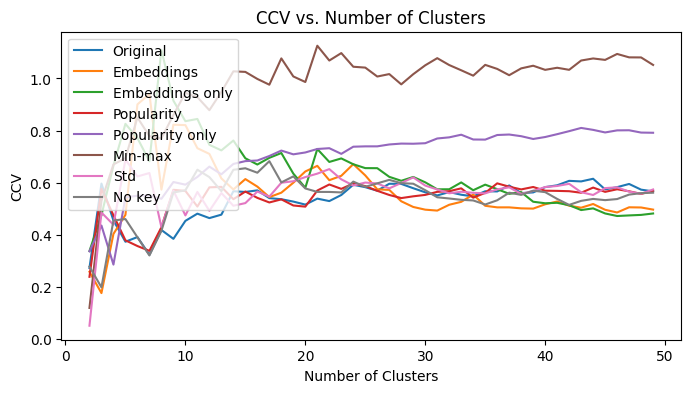

In [24]:
plt.figure(figsize=(8, 4))
for i in range(len(labels)):
    plt.plot(range(2, 50), variation_coefficients[i], label=labels[i]) # Cluster Coefficient of Variation
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('CCV')
plt.title('CCV vs. Number of Clusters')
plt.show()

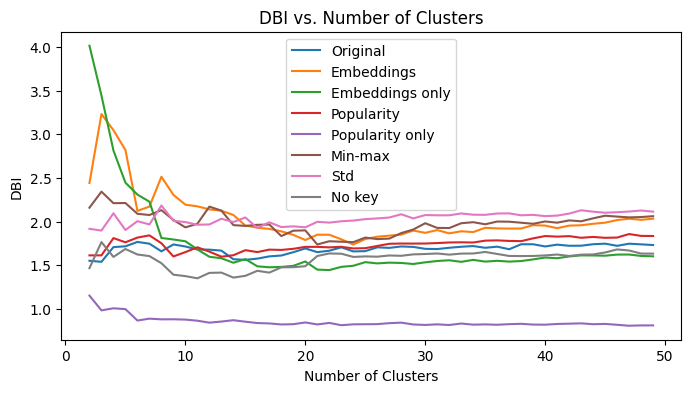

In [25]:
plt.figure(figsize=(8, 4))
for i in range(len(labels)):
    plt.plot(range(2, 50), davies_bouldins[i], label=labels[i]) # Davies-Bouldin Index
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('DBI')
plt.title('DBI vs. Number of Clusters')
plt.show()